# Neural Networks

This homework will be an extension of the lab we did working with CIFAR data (the homework doesn't come bundled with the data since you already have it from lab. If you don't have it you can get it from the lab from this week). We'll convert our network from a binary to a multiclass setting, much like you did with the MNIST data, and we'll experiment with some ways to improve network performance.

NOTE: We'll be talking about PyTorch during the week before this homework is due, but _don't_ use PyTorch for this homework. We'll switch over the PyTorch for the next one, but I think it's important to understand how the machine learning algorithms work under the hood.

First we'll load and normalize the data, just like we had in the lab.

In [13]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

def load_data(dirname):
    data = []
    labels = []
    for i in range(1, 6):
        with open(dirname + '/data_batch_' + str(i), 'rb') as fo:
            obj = pickle.load(fo, encoding='bytes')
            data.append(obj[b'data'])
            labels.append(obj[b'labels'])
    with open(dirname + '/batches.meta', 'rb') as fo:
        names = pickle.load(fo, encoding='bytes')[b'label_names']
    data = np.concatenate(data, axis=0)
    labels = np.concatenate(labels)
    return data.reshape(-1, 3, 32, 32), labels, names

In [14]:
# You may need to change the path below--it should point to the directory where
# the CIFAR data files are held on your system.
images, labels, names = load_data('../../data/cifar')
permute = np.random.permutation(labels.shape[0])
images = images[permute]
labels = labels[permute]

mean = np.mean(images, axis=(0, 2, 3), keepdims=True)
std = np.std(images, axis=(0, 2, 3), keepdims=True)

norm_images = (images - mean) / std

Now we'll set up and train a neural network to classify these images. There are different options you can choose from at different levels of complexity. The baseline assignment is to define a neural network with at least one hidden layer using ReLU as the activation function. Train your network using the multiclass cross-entropy loss we defined in the previous homework assignment. Completing this part of the assignment (correctly) guarantees at least a C.

Beyond this, I have two lists of possible extensions:

- Minor
  + Add $L_2$ regularization. That is, if your parameters are $\beta$, minimize $L(\beta) + \lambda \| \beta \|_2^2$. Remember that $\| \beta \|_2^2 = \sum_i \beta_i^2$. You'll need to compute the gradient of $\| \beta \|_2^2$ and add it to your gradients for each parameter. You'll need to choose a regularization hyperparameter $\lambda$. I recommend starting around 1e-4. How does this change your results (if at all)? (Note that the regularization in the lab solution is $L_1$ regularization, so this is slightly different.)
  + Use a different activation function to replace the ReLU. This will require computing the derivative of your new activation function and replacing the derivative of ReLU with it. (The derivative of ReLU is the line in the lab `h_grad[h <= 0] = 0`. We've already computed the derivative of $\tanh$ in a previous homework, so that might be a good choice.) How does this change your results (if at all)?
  + Split your data into a training set and a validation set. Track and plot the training accuracy and validation accuracy during training. What (if any) information can you get from this plot?
- Major
  + Define your training function to accept a _list_ of hidden layer sizes and set up the network accordingly. For example, I should be able to pass your function the list `[256, 128]` and it will create a network with two hidden layers of sizes 256 and 128. But if I pass it `[256, 128, 64]` then it should create a network with _three_ hidden layers of appropriate size.
  + Use at least two hidden layers and add data augmentation. That is, for each iteration of training, you should randomly perturb each image independently. A couple of good options are listed below. Implement at least two.
    * Horizontal flip: randomly mirror an image with probability 0.5
    * Grayscale: replace each color value with the average of all three color values in an image with probability 0.5
    * Brightness: choose a factor uniformly at random in some range around one (say 0.9-1.1) then multiply each pixel value by that factor. You can also choose different factors for each color channel.
    * Shift: randomly choose a number of pixels (our images are small so probably around 3 or 4 at most) and a direction. Shift the image by the chosen number of pixels in the chosen direction and fill in the leftover gap with the mean values of each color.
    
Using at least two hidden layers and doing any two of the minor extensions _or_ a major extension (correctly) guarantees a B. Doing all of the minor extensions and at least one of the major extensions (correctly) is good for an A.

In [ ]:
# Contributors
# 
# I got help from Patrick for some of the backpropagation calculations as well as details
# about grayscaling my images. I also got help from Addie for similar backpropagation 
# calculations.

def train(xs, ys, valid_xs, valid_ys, epochs=10, lr=5e-5, batch_size=64, reg=2e-4, data_aug=True):
    
    rng = np.random.default_rng()
    valid_accs = []
    train_accs = []
    e = list(range(0,epochs))

    # Getting our hidden layer sizes
    size1 = 512
    size2 = 256

    # Set up the model

    # We go from 512 -> 256 -> 10 which is our final prediction
    # This architecture uses 2 hidden layers like in the lab
    w1 = rng.normal(scale=np.sqrt(2/(xs.shape[1]+size1)), size=(xs.shape[1], size1))
    b1 = np.zeros(size1)
    w2 = rng.normal(scale=np.sqrt(2/(size1+size2)), size=(size1, size2))
    b2 = np.zeros(size2)
    w3 = rng.normal(scale=np.sqrt(2/(size2+10)), size=(size2, 10))
    b3 = np.zeros(10)

    # We also need the one-hot encoding for the gradient of softmax
    one_hot = np.zeros((ys.shape[0], 10))
    one_hot[np.arange(ys.shape[0]), ys] = 1
    
    num_batches = xs.shape[0] // batch_size
    if xs.shape[0] % batch_size != 0:
        num_batches += 1
        
    for i in range(epochs):
        
        # Shuffle the data at the start of each epoch
        permute = rng.permutation(xs.shape[0])
        xs = xs[permute]
        ys = ys[permute]
        one_hot = one_hot[permute]

        # Adding our data augmentation
        if data_aug:

            # Brightness
            brightness = rng.uniform(0.9, 1.1, size=(xs.shape[0], xs.shape[1]))
            aug_xs = xs * brightness

            # Grayscale
            aug_xs = aug_xs.reshape(-1, 3, 32, 32)
            is_grayscale = np.expand_dims(rng.random(size=(xs.shape[0])), axis=1)
            is_grayscale = np.tile(is_grayscale, (1, xs.shape[1])).reshape(-1, 3, 32, 32)
            grayscale_xs = np.mean(aug_xs, axis=1, keepdims=True)
            grayscale_xs = np.broadcast_to(grayscale_xs, shape=aug_xs.shape)
            aug_xs = np.where(is_grayscale < 0.5, aug_xs, grayscale_xs).reshape(-1, 3072)

        for j in range(num_batches):

            end_index = min(batch_size * (j + 1), xs.shape[0])

            # Using our augmented data
            if data_aug:
                batch_xs = aug_xs[batch_size * j : end_index]
            else:
                batch_xs = xs[batch_size * j : end_index]

            batch_ys = ys[batch_size * j : end_index]
            batch_one_hot = one_hot[batch_size * j : end_index]

            # We first compute the hs with our tanh activation function.
            h1 = np.tanh(batch_xs @ w1 + b1)
            h2 = np.tanh(h1 @ w2 + b2)
            
            # We then get the value we're going to plug into the softmax function
            logits = (h2 @ w3 + b3).squeeze()
            exp_logits = np.exp(logits)

            # Applying softmax like we did in HW2 and calculating which ones our model
            # got correct
            preds = exp_logits/np.expand_dims(np.sum(exp_logits, axis=1), axis=1)
            correct_preds = preds[np.arange(preds.shape[0]), batch_ys]

            # Calculating loss 
            loss = np.mean(-np.log(correct_preds))

            # Calculating the gradients
            logit_grad = preds-batch_one_hot
            b3_grad = np.sum(logit_grad, axis=0)
            w3_grad = h2.T @ logit_grad
            h2_grad = logit_grad @ w3.T
            h2_grad = (1 - np.power(np.tanh(h2), 2)) * h2_grad
            b2_grad = np.sum(h2_grad, axis=0)
            w2_grad = h1.T @ h2_grad
            h1_grad = h2_grad @ w2.T
            h1_grad = (1 - np.power(np.tanh(h1), 2)) * h1_grad
            b1_grad = np.sum(h1_grad, axis=0)
            w1_grad = batch_xs.T @ h1_grad

            # Applying L2 regularization
            w1_grad += reg * np.power(w1, 2)
            b1_grad += reg * np.power(b1, 2)
            h1_grad += reg * np.power(h1, 2)
            w2_grad += reg * np.power(w2, 2)
            b2_grad += reg * np.power(b2, 2)
            h2_grad += reg * np.power(h2, 2)
            w3_grad += reg * np.power(w3, 2)
            b3_grad += reg * np.power(b3, 2)

            # Modifying our parameters
            w1 -= lr * w1_grad
            b1 -= lr * b1_grad
            h1 -= lr * h1_grad
            w2 -= lr * w2_grad
            b2 -= lr * b2_grad
            h2 -= lr * h2_grad
            w3 -= lr * w3_grad
            b3 -= lr * b3_grad
           
        # Testing our validation accuracy   
        h1 = np.tanh(valid_xs @ w1 + b1)
        h2 = np.tanh(h1 @ w2 + b2)
        logits = (h2 @ w3 + b3).squeeze()
        preds = 1 / (1 + np.exp(-logits))
        preds_max = np.argmax(preds, axis=1)
        valid_acc = np.mean(preds_max == valid_ys)
        print("Epoch:", i, "Loss:", loss, "Validation accuracy:", valid_acc)
        valid_accs.append(valid_acc)

        # Testing our training accuracy
        train_h1 = np.tanh(xs @ w1 + b1)
        train_h2 = np.tanh(train_h1 @ w2 + b2)
        train_logits = (train_h2 @ w3 + b3).squeeze()
        train_preds = 1 / (1 + np.exp(-train_logits))
        train_preds_max = np.argmax(train_preds, axis=1)
        train_acc = np.mean(train_preds_max == ys)
        print("Epoch:", i, "Training accuracy:", train_acc)
        train_accs.append(train_acc)
    
    # Making a basic plot of our accuracy over time
    plt.plot(e, valid_accs, label='validation accuracy')
    plt.plot(e, train_accs, label='training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


## Notes on the Model

As you can see, I tried applying all of the minor extensions and the data augmentation major extension.

### Tanh vs ReLU

In general, I found that the tanh activation function was about 7% less effective than ReLU. While ReLU gave me roughly 50% validation accuracy, tanh topped out at about 43% and also converged in a less stable way. In general, I would probably use ReLU for this problem.

### L2 Regularization

I think that L2 regularization is fine. In practice, it behaved marginally better than L1 regularization for my tanh activation function. I used a 2e-4 regularization hyperparameter because it seemed to be working well. Tanh is still not terribly stable and will oscilate at higher validation accuracies regardless of regularization or learning rate.

### Validation Set
In the cell below, I split the training and validation set and provide a small plot to demonstrate the results. I found that the training data set yields a pretty significantly higher accuracy (~48%) in comparison to the validation set. This would lead me to believe there is some amount of overfitting going on here.

### Data Augmentation
The data augmentation didn't really seem to do anything for my results. I added a brightness transform and a grayscale transform but I don't notice much improvement in terms of the model accuracy. On that note, there is definitely something to be done about improving the computational efficiency of my grayscale calculation. However, this is the best I could come up with for now.

Epoch: 0 Loss: 1.8159863230704154 Validation accuracy: 0.3598
Epoch: 1 Loss: 1.8718509278073134 Validation accuracy: 0.3886
Epoch: 2 Loss: 1.7932474582381237 Validation accuracy: 0.3991
Epoch: 3 Loss: 1.838967869941158 Validation accuracy: 0.4069
Epoch: 4 Loss: 1.670406410905366 Validation accuracy: 0.4106
Epoch: 5 Loss: 1.8919929944020193 Validation accuracy: 0.4215
Epoch: 6 Loss: 1.6234398361943434 Validation accuracy: 0.4234
Epoch: 7 Loss: 1.7550478046652074 Validation accuracy: 0.4244
Epoch: 8 Loss: 1.7765172068501613 Validation accuracy: 0.4271
Epoch: 9 Loss: 1.6615167355280414 Validation accuracy: 0.4283


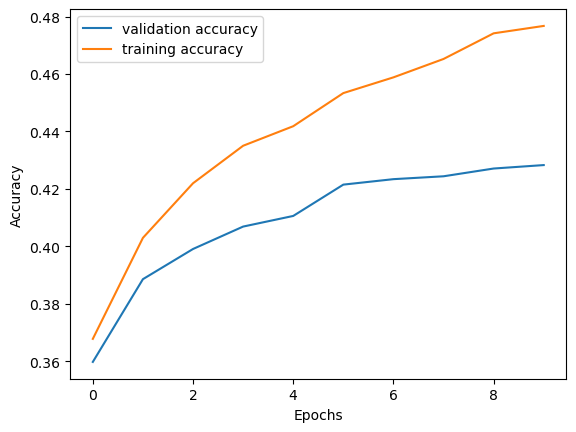

In [19]:
# Separating our data into a validation set and a training set
train_size = int(0.8 * norm_images.shape[0])
train_data = norm_images[:train_size]
train_labels = labels[:train_size]
valid_data = norm_images[train_size:]
valid_labels = labels[train_size:]

# Training our model
train(train_data.reshape(-1, 3*32*32), 
      train_labels, 
      valid_data.reshape(-1, 3*32*32),
      valid_labels,
      10)